In [1]:
import gym
import numpy as np

from functions import *
from numpy import load
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from numpy import save
from numpy import load
from sklearn import preprocessing
import math

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [3]:
def discretization(env, state):
    
    #states (observation) lower limit
    #2 dimensions: 
    #1st dimension = lower limit of position (1st state)
    #2nd dimension = lower limit of velocity (2nd state)
    env_low = env.observation_space.low
    
    #states (observaion) upper limit
    #2 dimensions: 
    #1st dimension = upper limit of position (1st state)
    #2nd dimension = upper limit of velocity (2nd state)
    env_high = env.observation_space.high
    
    #Interval for each state based on n_states
    #2 dimensions:
    #1st dimension: interval of position (1st state)
    #2nd dimension: interval of velocity (2nd state)
    env_den = (env_high - env_low)/n_states
    
    position_den = env_den[0]
    velocity_den = env_den[1]
    
    position_high = env_high[0]
    position_low = env_low[0]
    
    velocity_high = env_high[1]
    velocity_low = env_low[1]
    
    #scale the new/next state 
    position_scaled = int((state[0] - position_low)/position_den)
    velocity_scaled = int((state[1] - velocity_low)/velocity_den)
    
    return position_scaled, velocity_scaled

In [4]:
def rbf_transform(data,center,sigma):
    return np.exp(-(np.linalg.norm(data-center)**2) / sigma**2)

In [5]:
def generate_samples(env,n):
    sample_states = []

    for i in range(n):
        state = env.observation_space.sample()
        state = list(state)
        sample_states.append(state)

    sample_states = np.array(sample_states)
    
    scalerX = preprocessing.StandardScaler().fit(sample_states)

    sample_states = scalerX.transform(sample_states)
    
    return sample_states, scalerX

In [6]:
def predict(s0,s1,w,centers,std,scaler):
    x = np.array([[state[0],state[1]]])
    x = scaler.transform(x)
    x = np.array([x[0][0],x[0][1]])
    
    RBF = np.array([[rbf_transform(x,c,std) for c in centers]])
    RBF = np.reshape(RBF, (-1,1))

    out = RBF.T@w
    
    return RBF, out

In [7]:
#writer = SummaryWriter()

In [8]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)
state = env.reset()

env = env.unwrapped
env.seed()
np.random.seed(0)

In [9]:
sample_states, scalerX = generate_samples(env,5000)

C = 100
kmeans = KMeans(n_clusters=C, random_state=567).fit(sample_states)

std = np.std(sample_states)
centers = kmeans.cluster_centers_

In [10]:
#q_table = np.zeros((n_states, n_states, env.action_space.n))

In [11]:
n_states = 40
episodes = 1000
gamma = 0.95

In [12]:
lr = 0.001
min_lr = 0.001

epsilon = 0.1
min_epsilon = 0.02

w = np.random.rand(C,3)

episode_epsilon = []
all_rewards = []
errors = []
episode_steps = []
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    
    if episode%50 == 0 and episode != 0:
        #lr = lr*0.5
        epsilon = epsilon*0.9  

    lr = max(min_lr, lr)
    epsilon = max(min_epsilon, epsilon)
    
    steps = 0
    
    print('Episode:',episode, 'lr:', lr, 'epsilon:',epsilon)
    
    losses = []
    while True:
        env.render()

        RBF, out = predict(state[0],state[1],w,centers,std,scalerX)

        if np.random.uniform(low=0, high=1)<epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(out)

        state, reward, terminate, _ = env.step(a)
        
        RBF_next, out_next = predict(state[0],state[1],w,centers,std,scalerX)
        
        #Q-learning update rule
        #=====================================================
        target = out.copy()
        target[0][a] = reward + gamma*np.max(out_next)
        #=====================================================
        
        error = np.sum(np.abs(target - out))
        
        loss = target - out
        
        derivative = (-RBF) @ loss
        
        w = w - lr*derivative

        total_reward += reward
        steps += 1
        
        losses.append(error)
        

        if terminate:
            break
    
    episode_epsilon.append(epsilon)
    all_rewards.append(total_reward)
    errors.append(np.mean(losses))
    episode_steps.append(steps)
    
    print('Episode', episode, 'Total reward:', total_reward, 'Steps:', steps, 'Loss:',np.mean(losses))

env.close()
#writer.close() 

Episode: 0 lr: 0.001 epsilon: 0.1
Episode 0 Total reward: -3611.0 Steps: 3611 Loss: 1.1990010458495926
Episode: 1 lr: 0.001 epsilon: 0.1
Episode 1 Total reward: -3470.0 Steps: 3470 Loss: 0.6349655699896554
Episode: 2 lr: 0.001 epsilon: 0.1
Episode 2 Total reward: -246.0 Steps: 246 Loss: 0.6579346197922326
Episode: 3 lr: 0.001 epsilon: 0.1
Episode 3 Total reward: -1252.0 Steps: 1252 Loss: 0.8531547123241616
Episode: 4 lr: 0.001 epsilon: 0.1
Episode 4 Total reward: -705.0 Steps: 705 Loss: 0.5943361507055623
Episode: 5 lr: 0.001 epsilon: 0.1
Episode 5 Total reward: -371.0 Steps: 371 Loss: 0.4799358801809346
Episode: 6 lr: 0.001 epsilon: 0.1
Episode 6 Total reward: -464.0 Steps: 464 Loss: 0.46912451856296705
Episode: 7 lr: 0.001 epsilon: 0.1
Episode 7 Total reward: -335.0 Steps: 335 Loss: 0.568901468605572
Episode: 8 lr: 0.001 epsilon: 0.1
Episode 8 Total reward: -386.0 Steps: 386 Loss: 0.44197995864909306
Episode: 9 lr: 0.001 epsilon: 0.1
Episode 9 Total reward: -484.0 Steps: 484 Loss: 0.

Episode 75 Total reward: -1373.0 Steps: 1373 Loss: 0.12175341311782018
Episode: 76 lr: 0.001 epsilon: 0.09000000000000001
Episode 76 Total reward: -232.0 Steps: 232 Loss: 0.31740841819792
Episode: 77 lr: 0.001 epsilon: 0.09000000000000001
Episode 77 Total reward: -230.0 Steps: 230 Loss: 0.1797813703067395
Episode: 78 lr: 0.001 epsilon: 0.09000000000000001
Episode 78 Total reward: -1082.0 Steps: 1082 Loss: 0.13023627146679073
Episode: 79 lr: 0.001 epsilon: 0.09000000000000001
Episode 79 Total reward: -390.0 Steps: 390 Loss: 0.20112600260946512
Episode: 80 lr: 0.001 epsilon: 0.09000000000000001
Episode 80 Total reward: -598.0 Steps: 598 Loss: 0.149449280105482
Episode: 81 lr: 0.001 epsilon: 0.09000000000000001
Episode 81 Total reward: -384.0 Steps: 384 Loss: 0.162093970271873
Episode: 82 lr: 0.001 epsilon: 0.09000000000000001
Episode 82 Total reward: -236.0 Steps: 236 Loss: 0.33480216424706344
Episode: 83 lr: 0.001 epsilon: 0.09000000000000001
Episode 83 Total reward: -1563.0 Steps: 1563

Episode 143 Total reward: -1055.0 Steps: 1055 Loss: 0.10313164941044718
Episode: 144 lr: 0.001 epsilon: 0.08100000000000002
Episode 144 Total reward: -3597.0 Steps: 3597 Loss: 0.06875937064696659
Episode: 145 lr: 0.001 epsilon: 0.08100000000000002
Episode 145 Total reward: -292.0 Steps: 292 Loss: 0.22708810118440417
Episode: 146 lr: 0.001 epsilon: 0.08100000000000002
Episode 146 Total reward: -225.0 Steps: 225 Loss: 0.2034222236671718
Episode: 147 lr: 0.001 epsilon: 0.08100000000000002
Episode 147 Total reward: -1078.0 Steps: 1078 Loss: 0.09254974261059198
Episode: 148 lr: 0.001 epsilon: 0.08100000000000002
Episode 148 Total reward: -686.0 Steps: 686 Loss: 0.10817898563460214
Episode: 149 lr: 0.001 epsilon: 0.08100000000000002
Episode 149 Total reward: -226.0 Steps: 226 Loss: 0.21036453726750357
Episode: 150 lr: 0.001 epsilon: 0.07290000000000002
Episode 150 Total reward: -1370.0 Steps: 1370 Loss: 0.08297058252494449
Episode: 151 lr: 0.001 epsilon: 0.07290000000000002
Episode 151 Total

Episode 210 Total reward: -389.0 Steps: 389 Loss: 0.11469099698880308
Episode: 211 lr: 0.001 epsilon: 0.06561000000000002
Episode 211 Total reward: -297.0 Steps: 297 Loss: 0.13140296974670845
Episode: 212 lr: 0.001 epsilon: 0.06561000000000002
Episode 212 Total reward: -155.0 Steps: 155 Loss: 0.17938719335433764
Episode: 213 lr: 0.001 epsilon: 0.06561000000000002
Episode 213 Total reward: -522.0 Steps: 522 Loss: 0.08307842889868061
Episode: 214 lr: 0.001 epsilon: 0.06561000000000002
Episode 214 Total reward: -235.0 Steps: 235 Loss: 0.1398176955279087
Episode: 215 lr: 0.001 epsilon: 0.06561000000000002
Episode 215 Total reward: -157.0 Steps: 157 Loss: 0.2036483406637286
Episode: 216 lr: 0.001 epsilon: 0.06561000000000002
Episode 216 Total reward: -150.0 Steps: 150 Loss: 0.18509027140273795
Episode: 217 lr: 0.001 epsilon: 0.06561000000000002
Episode 217 Total reward: -155.0 Steps: 155 Loss: 0.19674270224495605
Episode: 218 lr: 0.001 epsilon: 0.06561000000000002
Episode 218 Total reward: 

Episode 277 Total reward: -153.0 Steps: 153 Loss: 0.15270085290712843
Episode: 278 lr: 0.001 epsilon: 0.05904900000000002
Episode 278 Total reward: -919.0 Steps: 919 Loss: 0.03814410292720229
Episode: 279 lr: 0.001 epsilon: 0.05904900000000002
Episode 279 Total reward: -154.0 Steps: 154 Loss: 0.17359135969506376
Episode: 280 lr: 0.001 epsilon: 0.05904900000000002
Episode 280 Total reward: -153.0 Steps: 153 Loss: 0.15607857712150208
Episode: 281 lr: 0.001 epsilon: 0.05904900000000002
Episode 281 Total reward: -154.0 Steps: 154 Loss: 0.14433142324890263
Episode: 282 lr: 0.001 epsilon: 0.05904900000000002
Episode 282 Total reward: -686.0 Steps: 686 Loss: 0.05616573734885266
Episode: 283 lr: 0.001 epsilon: 0.05904900000000002
Episode 283 Total reward: -467.0 Steps: 467 Loss: 0.06421880141641421
Episode: 284 lr: 0.001 epsilon: 0.05904900000000002
Episode 284 Total reward: -224.0 Steps: 224 Loss: 0.11125615797976061
Episode: 285 lr: 0.001 epsilon: 0.05904900000000002
Episode 285 Total reward

Episode 345 Total reward: -1213.0 Steps: 1213 Loss: 0.0398669818080443
Episode: 346 lr: 0.001 epsilon: 0.05314410000000002
Episode 346 Total reward: -153.0 Steps: 153 Loss: 0.15941687921661268
Episode: 347 lr: 0.001 epsilon: 0.05314410000000002
Episode 347 Total reward: -152.0 Steps: 152 Loss: 0.14803358343960948
Episode: 348 lr: 0.001 epsilon: 0.05314410000000002
Episode 348 Total reward: -155.0 Steps: 155 Loss: 0.148242678710504
Episode: 349 lr: 0.001 epsilon: 0.05314410000000002
Episode 349 Total reward: -151.0 Steps: 151 Loss: 0.15363011193518197
Episode: 350 lr: 0.001 epsilon: 0.04782969000000002
Episode 350 Total reward: -6445.0 Steps: 6445 Loss: 0.02292450889987386
Episode: 351 lr: 0.001 epsilon: 0.04782969000000002
Episode 351 Total reward: -157.0 Steps: 157 Loss: 0.1392837105121037
Episode: 352 lr: 0.001 epsilon: 0.04782969000000002
Episode 352 Total reward: -150.0 Steps: 150 Loss: 0.15076331453597572
Episode: 353 lr: 0.001 epsilon: 0.04782969000000002
Episode 353 Total reward

Episode 412 Total reward: -149.0 Steps: 149 Loss: 0.15453757111479885
Episode: 413 lr: 0.001 epsilon: 0.043046721000000024
Episode 413 Total reward: -149.0 Steps: 149 Loss: 0.15508752087396438
Episode: 414 lr: 0.001 epsilon: 0.043046721000000024
Episode 414 Total reward: -149.0 Steps: 149 Loss: 0.14929675524389938
Episode: 415 lr: 0.001 epsilon: 0.043046721000000024
Episode 415 Total reward: -149.0 Steps: 149 Loss: 0.14467501828459664
Episode: 416 lr: 0.001 epsilon: 0.043046721000000024
Episode 416 Total reward: -150.0 Steps: 150 Loss: 0.1548469810466568
Episode: 417 lr: 0.001 epsilon: 0.043046721000000024
Episode 417 Total reward: -1083.0 Steps: 1083 Loss: 0.04149545990765199
Episode: 418 lr: 0.001 epsilon: 0.043046721000000024
Episode 418 Total reward: -5003.0 Steps: 5003 Loss: 0.02442936323128746
Episode: 419 lr: 0.001 epsilon: 0.043046721000000024
Episode 419 Total reward: -149.0 Steps: 149 Loss: 0.14961227263854132
Episode: 420 lr: 0.001 epsilon: 0.043046721000000024
Episode 420 T

Episode 479 Total reward: -149.0 Steps: 149 Loss: 0.1538318968941357
Episode: 480 lr: 0.001 epsilon: 0.03874204890000002
Episode 480 Total reward: -147.0 Steps: 147 Loss: 0.14457776957963703
Episode: 481 lr: 0.001 epsilon: 0.03874204890000002
Episode 481 Total reward: -7607.0 Steps: 7607 Loss: 0.01428412748171452
Episode: 482 lr: 0.001 epsilon: 0.03874204890000002
Episode 482 Total reward: -1221.0 Steps: 1221 Loss: 0.018429271671619882
Episode: 483 lr: 0.001 epsilon: 0.03874204890000002
Episode 483 Total reward: -147.0 Steps: 147 Loss: 0.08751565402665891
Episode: 484 lr: 0.001 epsilon: 0.03874204890000002
Episode 484 Total reward: -155.0 Steps: 155 Loss: 0.12940489077660994
Episode: 485 lr: 0.001 epsilon: 0.03874204890000002
Episode 485 Total reward: -174.0 Steps: 174 Loss: 0.19189431252621614
Episode: 486 lr: 0.001 epsilon: 0.03874204890000002
Episode 486 Total reward: -147.0 Steps: 147 Loss: 0.13215717234121585
Episode: 487 lr: 0.001 epsilon: 0.03874204890000002
Episode 487 Total re

Episode 547 Total reward: -141.0 Steps: 141 Loss: 0.14636594174996417
Episode: 548 lr: 0.001 epsilon: 0.03486784401000002
Episode 548 Total reward: -153.0 Steps: 153 Loss: 0.15553264361985955
Episode: 549 lr: 0.001 epsilon: 0.03486784401000002
Episode 549 Total reward: -138.0 Steps: 138 Loss: 0.14415563930937808
Episode: 550 lr: 0.001 epsilon: 0.03138105960900001
Episode 550 Total reward: -161.0 Steps: 161 Loss: 0.1654688303188608
Episode: 551 lr: 0.001 epsilon: 0.03138105960900001
Episode 551 Total reward: -141.0 Steps: 141 Loss: 0.14624942846101724
Episode: 552 lr: 0.001 epsilon: 0.03138105960900001
Episode 552 Total reward: -160.0 Steps: 160 Loss: 0.16264998715230278
Episode: 553 lr: 0.001 epsilon: 0.03138105960900001
Episode 553 Total reward: -140.0 Steps: 140 Loss: 0.14224628262676112
Episode: 554 lr: 0.001 epsilon: 0.03138105960900001
Episode 554 Total reward: -139.0 Steps: 139 Loss: 0.14387885711428214
Episode: 555 lr: 0.001 epsilon: 0.03138105960900001
Episode 555 Total reward:

Episode 615 Total reward: -185.0 Steps: 185 Loss: 0.12759427612727975
Episode: 616 lr: 0.001 epsilon: 0.028242953648100012
Episode 616 Total reward: -121.0 Steps: 121 Loss: 0.06326224635997796
Episode: 617 lr: 0.001 epsilon: 0.028242953648100012
Episode 617 Total reward: -266.0 Steps: 266 Loss: 0.10373389875800498
Episode: 618 lr: 0.001 epsilon: 0.028242953648100012
Episode 618 Total reward: -2714.0 Steps: 2714 Loss: 0.026273046681142446
Episode: 619 lr: 0.001 epsilon: 0.028242953648100012
Episode 619 Total reward: -425.0 Steps: 425 Loss: 0.0802321316120984
Episode: 620 lr: 0.001 epsilon: 0.028242953648100012
Episode 620 Total reward: -117.0 Steps: 117 Loss: 0.12506404899252008
Episode: 621 lr: 0.001 epsilon: 0.028242953648100012
Episode 621 Total reward: -119.0 Steps: 119 Loss: 0.12192892474354008
Episode: 622 lr: 0.001 epsilon: 0.028242953648100012
Episode 622 Total reward: -119.0 Steps: 119 Loss: 0.05960660790494861
Episode: 623 lr: 0.001 epsilon: 0.028242953648100012
Episode 623 To

Episode 682 Total reward: -262.0 Steps: 262 Loss: 0.09989489588244725
Episode: 683 lr: 0.001 epsilon: 0.025418658283290013
Episode 683 Total reward: -871.0 Steps: 871 Loss: 0.05239156140269931
Episode: 684 lr: 0.001 epsilon: 0.025418658283290013
Episode 684 Total reward: -258.0 Steps: 258 Loss: 0.0905338092944277
Episode: 685 lr: 0.001 epsilon: 0.025418658283290013
Episode 685 Total reward: -564.0 Steps: 564 Loss: 0.058665664902770386
Episode: 686 lr: 0.001 epsilon: 0.025418658283290013
Episode 686 Total reward: -1948.0 Steps: 1948 Loss: 0.024005686368662082
Episode: 687 lr: 0.001 epsilon: 0.025418658283290013
Episode 687 Total reward: -405.0 Steps: 405 Loss: 0.07224998402987452
Episode: 688 lr: 0.001 epsilon: 0.025418658283290013
Episode 688 Total reward: -188.0 Steps: 188 Loss: 0.14379315792305244
Episode: 689 lr: 0.001 epsilon: 0.025418658283290013
Episode 689 Total reward: -194.0 Steps: 194 Loss: 0.15433816484269414
Episode: 690 lr: 0.001 epsilon: 0.025418658283290013
Episode 690 T

Episode 749 Total reward: -791.0 Steps: 791 Loss: 0.032646752590463325
Episode: 750 lr: 0.001 epsilon: 0.020589113209464913
Episode 750 Total reward: -188.0 Steps: 188 Loss: 0.14478412242855263
Episode: 751 lr: 0.001 epsilon: 0.020589113209464913
Episode 751 Total reward: -183.0 Steps: 183 Loss: 0.06885108693703482
Episode: 752 lr: 0.001 epsilon: 0.020589113209464913
Episode 752 Total reward: -1831.0 Steps: 1831 Loss: 0.019133900583265796
Episode: 753 lr: 0.001 epsilon: 0.020589113209464913
Episode 753 Total reward: -1644.0 Steps: 1644 Loss: 0.02323573597545937
Episode: 754 lr: 0.001 epsilon: 0.020589113209464913
Episode 754 Total reward: -181.0 Steps: 181 Loss: 0.07717922527787985
Episode: 755 lr: 0.001 epsilon: 0.020589113209464913
Episode 755 Total reward: -192.0 Steps: 192 Loss: 0.06239841001321644
Episode: 756 lr: 0.001 epsilon: 0.020589113209464913
Episode 756 Total reward: -199.0 Steps: 199 Loss: 0.07866155203827245
Episode: 757 lr: 0.001 epsilon: 0.020589113209464913
Episode 75

Episode 818 Total reward: -1377.0 Steps: 1377 Loss: 0.02394201263764058
Episode: 819 lr: 0.001 epsilon: 0.02
Episode 819 Total reward: -2449.0 Steps: 2449 Loss: 0.018742843959579283
Episode: 820 lr: 0.001 epsilon: 0.02
Episode 820 Total reward: -255.0 Steps: 255 Loss: 0.11327360010071881
Episode: 821 lr: 0.001 epsilon: 0.02
Episode 821 Total reward: -176.0 Steps: 176 Loss: 0.12193309868747919
Episode: 822 lr: 0.001 epsilon: 0.02
Episode 822 Total reward: -265.0 Steps: 265 Loss: 0.1195210127212455
Episode: 823 lr: 0.001 epsilon: 0.02
Episode 823 Total reward: -178.0 Steps: 178 Loss: 0.07478652279697587
Episode: 824 lr: 0.001 epsilon: 0.02
Episode 824 Total reward: -1376.0 Steps: 1376 Loss: 0.03197856174580691
Episode: 825 lr: 0.001 epsilon: 0.02
Episode 825 Total reward: -1690.0 Steps: 1690 Loss: 0.025211692656103145
Episode: 826 lr: 0.001 epsilon: 0.02
Episode 826 Total reward: -404.0 Steps: 404 Loss: 0.05396325233881994
Episode: 827 lr: 0.001 epsilon: 0.02
Episode 827 Total reward: -1

Episode 895 Total reward: -264.0 Steps: 264 Loss: 0.11696497810342493
Episode: 896 lr: 0.001 epsilon: 0.02
Episode 896 Total reward: -2441.0 Steps: 2441 Loss: 0.016054530471492745
Episode: 897 lr: 0.001 epsilon: 0.02
Episode 897 Total reward: -304.0 Steps: 304 Loss: 0.05710415292215654
Episode: 898 lr: 0.001 epsilon: 0.02
Episode 898 Total reward: -1635.0 Steps: 1635 Loss: 0.024609628118773735
Episode: 899 lr: 0.001 epsilon: 0.02
Episode 899 Total reward: -239.0 Steps: 239 Loss: 0.06076061636562163
Episode: 900 lr: 0.001 epsilon: 0.02
Episode 900 Total reward: -284.0 Steps: 284 Loss: 0.13166803751742176
Episode: 901 lr: 0.001 epsilon: 0.02
Episode 901 Total reward: -239.0 Steps: 239 Loss: 0.06217225738784261
Episode: 902 lr: 0.001 epsilon: 0.02
Episode 902 Total reward: -384.0 Steps: 384 Loss: 0.06522639982237817
Episode: 903 lr: 0.001 epsilon: 0.02
Episode 903 Total reward: -308.0 Steps: 308 Loss: 0.055238712588270934
Episode: 904 lr: 0.001 epsilon: 0.02
Episode 904 Total reward: -194

Episode 972 Total reward: -881.0 Steps: 881 Loss: 0.03406920160095882
Episode: 973 lr: 0.001 epsilon: 0.02
Episode 973 Total reward: -242.0 Steps: 242 Loss: 0.0449733417593623
Episode: 974 lr: 0.001 epsilon: 0.02
Episode 974 Total reward: -976.0 Steps: 976 Loss: 0.014534757927356107
Episode: 975 lr: 0.001 epsilon: 0.02
Episode 975 Total reward: -239.0 Steps: 239 Loss: 0.04326083095205659
Episode: 976 lr: 0.001 epsilon: 0.02
Episode 976 Total reward: -372.0 Steps: 372 Loss: 0.06126227809293425
Episode: 977 lr: 0.001 epsilon: 0.02
Episode 977 Total reward: -301.0 Steps: 301 Loss: 0.05454917784979993
Episode: 978 lr: 0.001 epsilon: 0.02
Episode 978 Total reward: -248.0 Steps: 248 Loss: 0.070944859309687
Episode: 979 lr: 0.001 epsilon: 0.02
Episode 979 Total reward: -366.0 Steps: 366 Loss: 0.05179652864301538
Episode: 980 lr: 0.001 epsilon: 0.02
Episode 980 Total reward: -296.0 Steps: 296 Loss: 0.04099303119073713
Episode: 981 lr: 0.001 epsilon: 0.02
Episode 981 Total reward: -255.0 Steps:

In [ ]:
#env.close()
#writer.close() 

In [13]:
save('w_Q_Learning_1.npy', w)
save('episode_epsilon_RBF_Q_Learning_1.npy', episode_epsilon)
save('all_rewards_Q_Learning_1.npy', all_rewards)
save('errors_RBF_Q_Learning_1.npy', errors)
save('episode_steps_RBF_Q_Learning_1.npy', episode_steps)  

Text(0.5, 1.0, 'Episode_Steps')

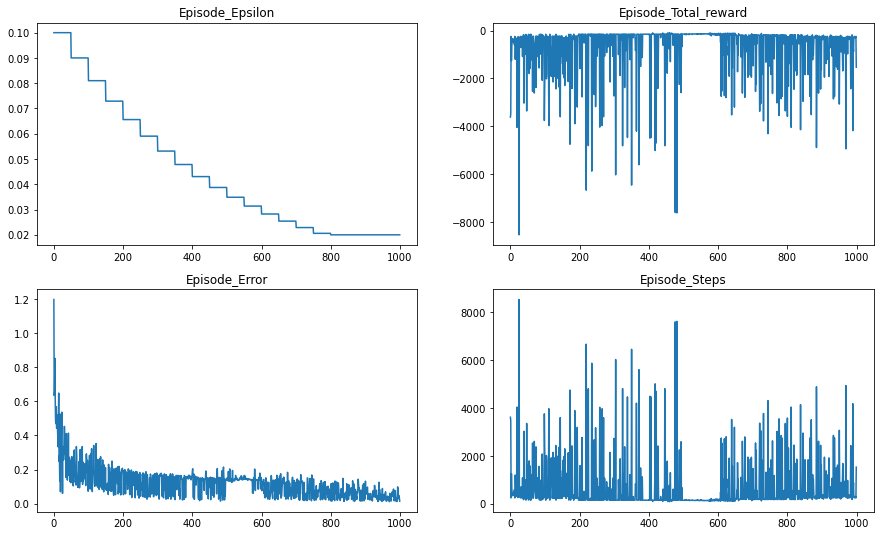

In [14]:
figure, axis = plt.subplots(2, 2, figsize=(15,9))

axis[0, 0].plot(episode_epsilon)
axis[0, 0].set_title("Episode_Epsilon")
  
axis[0, 1].plot(all_rewards)
axis[0, 1].set_title("Episode_Total_reward")
  
axis[1, 0].plot(errors)
axis[1, 0].set_title("Episode_Error")
  
axis[1, 1].plot(episode_steps)
axis[1, 1].set_title("Episode_Steps")

In [15]:
figure.savefig('RBF_Q_Learning_1.png')